# Performance analysis

In [1]:
import numpy as np
from decimal import Decimal
import matplotlib.pyplot as plt

Setting up variables and functions for converting cycles to ms. 

In [2]:
cyclesperms = 4100000
def convert_cycles_to_ms(x):
    return x/cyclesperms

def ms_round(x):
    return float(round(Decimal(convert_cycles_to_ms(x)),1))

def bitstokb(x):
    return float(round(Decimal(x/(8*1024)),2))

Setting up the sizes of the elements in the BLS12-381 curve groups (in bits).

In [3]:
G1size = np.ceil(381/8)*8
G2size = 2*G1size+8
Gtsize = 12*G1size
Zpsize = np.ceil(255/8)*8

Initiating operational costs of the group operations (from the ABE Squared paper https://ia.cr/2022/038).

In [4]:
# group G
g1_mul = 184000
g1_mul_fix = 102000
g1_map = 225000

# group H
g2_mul = 324000 
g2_mul_fix = 247000
g2_map = 548000

# group Gt
gt_exp = 496000

# pairing operations
pair = 1245000
pair_one_more = 1618000 - 1245000

## Functions to compute the costs for the compared schemes

*Storage costs*

In [5]:
def pubkeysizeVen23():
    return Gtsize + 2*G1size

def pubkeysizeISABELLA():
    return 3*G1size

def pubkeysizeRW15():
    return 1*Gtsize + 1*G1size

def pubkeysizeAG21():
    return 4*G1size



def keysizeVen23(atts):
    return (2 + atts)*G2size

def keysizeISABELLA(atts):
    return (2 + atts)*G2size

def keysizeRW15(atts):
    return atts*G1size + atts*G2size

def keysizeAG21(atts):
    return atts*2*G2size



def ciphertextsizeVen23(atts,m):
    return m*G2size + 3*atts*G1size + atts*Gtsize

def ciphertextsizeISABELLA(atts,m):
    return m*G2size + 4*atts*G1size

def ciphertextsizeRW15(atts,m):
    return atts*Gtsize + 2*atts*G1size + atts*G2size

def ciphertextsizeAG21(atts,m,atts_aut):
    return atts_aut*G1size + 3*atts*G1size

*Computational costs*

In [6]:
def keycostVen23(atts):
    return g2_mul_fix + (g2_mul_fix + g2_map + g2_mul) + atts*(g1_map + g1_mul)

def keycostISABELLA(atts):
    return g2_mul_fix + (g2_mul_fix + g2_map + g2_mul) + atts*(g1_map + g1_mul)

def keycostRW15(atts):
    return atts*g1_mul_fix + g2_map + atts*(g2_map + 2*g2_mul)

def keycostAG21(atts):
    return g2_map + atts*g2_mul_fix + atts*(g2_mul_fix+g2_mul)



def enccostVen23(atts,m):
    return m*g2_mul_fix + atts*g1_mul_fix + atts*(g1_mul_fix + g1_mul) + atts*(2*g1_mul+g1_map) + atts*2*gt_exp

def enccostISABELLA(atts,m):
    return m*g2_mul_fix + atts*g1_mul_fix + atts*(g1_mul_fix + g1_mul) + atts*(2*g1_mul+g1_map) + atts*2*g1_mul

def enccostRW15(atts,m):
    return atts*g2_mul + atts*g1_mul_fix + 2*atts*gt_exp + atts*(g1_mul+g1_mul_fix)

def enccostAG21(atts,m,atts_aut):
    return 3*atts_aut*g1_mul + (2*atts+atts_aut)*g1_mul_fix + 1*atts*g1_mul



def deccostVen23(atts,m,aut):
    return g2_map + pair + (2*aut+m)*pair_one_more

def deccostISABELLA(atts,m,aut):
    return g2_map + pair + (2*aut+m+1)*pair_one_more

def deccostRW15(atts,m,aut):
    return g2_map + pair + (2*atts)*pair_one_more

def deccostAG21(atts,m,aut,atts_aut):
    return g2_map + pair + (1+atts+atts_aut)*pair_one_more

Settings and functions to plot everything.

In [7]:
def determinelabels(cost, opt):
    if cost == 'S':
        ylab = 'Size in KB'
        if opt == 'SK':
            title = 'Key sizes'
            xlab = 'Size of the set of attributes'
        if opt == 'CT':
            title = 'Ciphertext sizes'
            xlab = 'Length of the policy'
    if cost == 'C':
        ylab = 'Time in ms'
        if opt == 'KG':
            title = 'Key generation costs'
            xlab = 'Size of the set of attributes'
        if opt == 'Enc':
            title = 'Encryption costs'
            xlab = 'Length of the policy'
        if opt == 'Dec':
            title = 'Decryption costs'
            xlab = 'Number of matching attributes'
    return (xlab,ylab,title)

In [8]:
def determinefunc(scheme, cost, opt):
    if scheme == 'Ven23':
        if cost == 'S':
            if opt == 'MPK':
                return lambda _1,_2,_3,_4: pubkeysizeVen23
            if opt == 'SK':
                return lambda atts,_2,_3,_4: keysizeVen23(atts)
            if opt == 'CT':
                return lambda atts,m,_3,_4: ciphertextsizeVen23(atts,m)
        if cost == 'C':
            if opt == 'KG':
                return lambda atts,_2,_3,_4: keycostVen23(atts)
            if opt == 'Enc':
                return lambda atts,m,_3,_4: enccostVen23(atts,m)
            if opt == 'Dec':
                return lambda atts,m,aut,_4: deccostVen23(atts,m,aut)
    if scheme == 'ISABELLA':
        if cost == 'S':
            if opt == 'MPK':
                return lambda _1,_2,_3,_4: pubkeysizeISABELLA
            if opt == 'SK':
                return lambda atts,_2,_3,_4: keysizeISABELLA(atts)
            if opt == 'CT':
                return lambda atts,m,_3,_4: ciphertextsizeISABELLA(atts,m)
        if cost == 'C':
            if opt == 'KG':
                return lambda atts,_2,_3,_4: keycostISABELLA(atts)
            if opt == 'Enc':
                return lambda atts,m,_3,_4: enccostISABELLA(atts,m)
            if opt == 'Dec':
                return lambda atts,m,aut,_4: deccostISABELLA(atts,m,aut)
    if scheme == 'RW15':
        if cost == 'S':
            if opt == 'MPK':
                return lambda _1,_2,_3,_4: pubkeysizeRW15
            if opt == 'SK':
                return lambda atts,_2,_3,_4: keysizeRW15(atts)
            if opt == 'CT':
                return lambda atts,m,_3,_4: ciphertextsizeRW15(atts,m)
        if cost == 'C':
            if opt == 'KG':
                return lambda atts,_2,_3,_4: keycostRW15(atts)
            if opt == 'Enc':
                return lambda atts,m,_3,_4: enccostRW15(atts,m)
            if opt == 'Dec':
                return lambda atts,m,aut,_4: deccostRW15(atts,m,aut)
    if scheme == 'AG21':
        if cost == 'S':
            if opt == 'MPK':
                return lambda _1,_2,_3,_4: pubkeysizeAG21
            if opt == 'SK':
                return lambda atts,_2,_3,_4: keysizeAG21(atts)
            if opt == 'CT':
                return lambda atts,m,_3,atts_aut: ciphertextsizeAG21(atts,m,atts_aut)
        if cost == 'C':
            if opt == 'KG':
                return lambda atts,_2,_3,_4: keycostAG21(atts)
            if opt == 'Enc':
                return lambda atts,m,_3,atts_aut: enccostAG21(atts,m,atts_aut)
            if opt == 'Dec':
                return lambda atts,m,aut,atts_aut: deccostAG21(atts,m,aut,atts_aut)
    return lambda x: x

In [9]:
def plotcosts(cost, opt, lis):
    sizes = list(range(0,maxsize+1,10))[1:]
    nrmarks = len(lis)
    markers = ["$" + str(i+1) + "$" for i in range(nrmarks)]
    plt.style.use("ggplot")
    
    if cost == 'C':
        rnd = ms_round
    else: 
        rnd = bitstokb
    
    c = 0
    for scheme in lis:
        sch = []
        for atts in sizes:
            sch.append(rnd(determinefunc(scheme, cost, opt)(atts,m_use,int(aut_dec/10),int(atts_aut/10))))
        plt.plot(sizes, sch, label=scheme, marker=markers[c], markevery=(c*5,nrmarks*5))
        c += 1

        data=''
        for x,y in zip(sizes,sch):
            data+= str(x) + ' ' + str(y) + '\n'
        # print(data)
    
    (xlab,ylab,title) = determinelabels(cost, opt)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.legend()
    
    pref = opt + "-all"
    
    plt.savefig(pref + ".jpg")
    
    plt.show()
    plt.close()

In [10]:
def SKcosts():
    plotcosts('S', 'SK', listoplot)
    
def CTcosts():
    plotcosts('S', 'CT', listoplot)

def keygencosts():
    plotcosts('C', 'KG', listoplot)

def encryptioncosts():
    plotcosts('C', 'Enc', listoplot)
    
def decryptioncosts():
    plotcosts('C', 'Dec', listoplot)
    
def plotall():
    SKcosts()
    CTcosts()
    keygencosts()
    encryptioncosts()
    decryptioncosts()

**Making lists to plot**

In [11]:
maxsize = 100
m_use = 1
aut_dec = 10
atts_aut = 10

global listoplot
listoplot = ['RW15','AG21','Ven23','ISABELLA']

**Plots for the schemes**

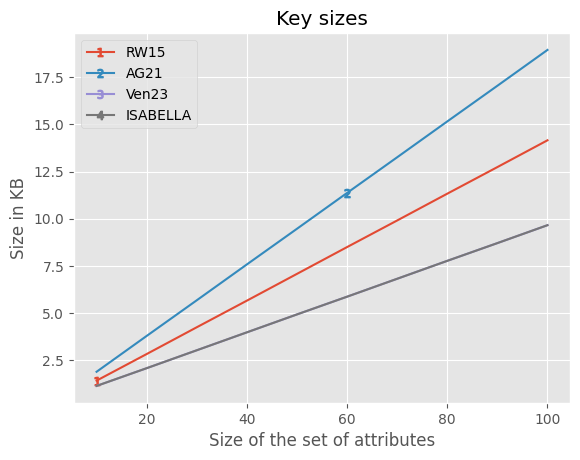

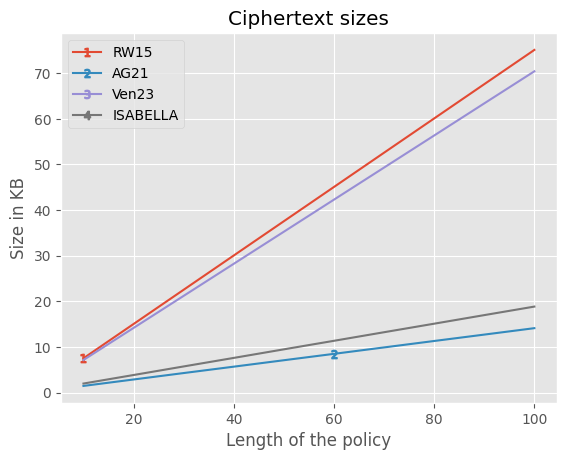

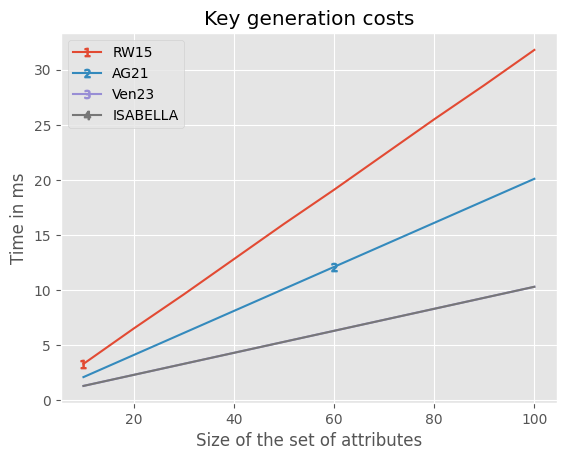

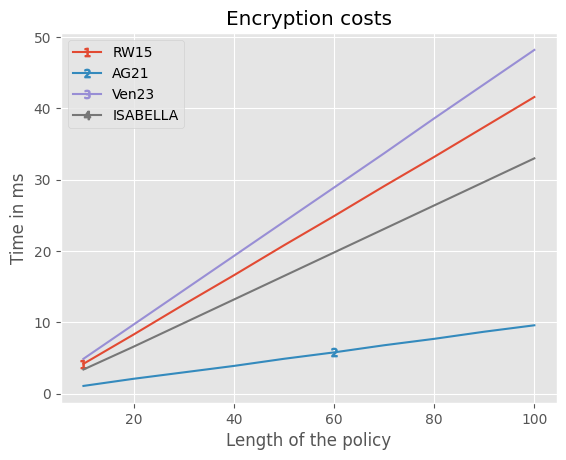

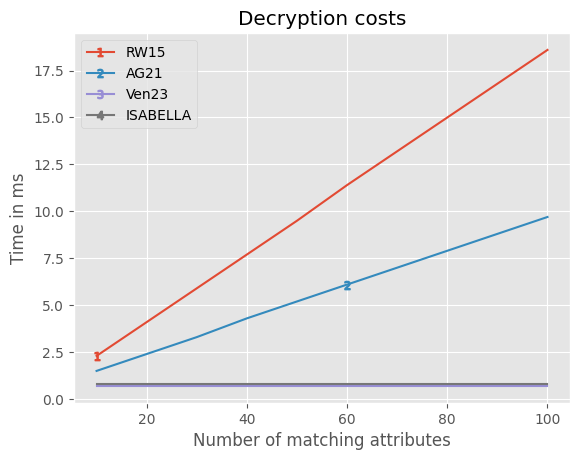

In [12]:
plotall()